

# Code References:
1.   Unsupervised_hello_world.Ipynb at master · tensorflow/similarity. [link text](https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb)
2.   B. Ko, CBAM-keras: CBAM implementation on keras. [link text]( https://github.com/kobiso/CBAM-keras)
3.   Keras Team, “Grad-CAM class activation visualization,” Keras.io. [Online]. Available: [link text](https://keras.io/examples/vision/grad_cam/)
4.   S. Loukas, “Multi-class Classification: Extracting performance metrics from the confusion matrix,” Towards Data Science, 19-Jun-2020. [Online]. Available: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872. [Accessed: 30-Apr-2022].






In [ ]:
!pip install tensorflow-addons --quiet
!pip install tensorflow_similarity --quiet

     |████████████████████████████████| 1.1 MB 30.8 MB/s 
     |████████████████████████████████| 191 kB 28.3 MB/s 
     |████████████████████████████████| 4.2 MB 61.1 MB/s 
     |████████████████████████████████| 88 kB 8.9 MB/s 
     |████████████████████████████████| 13.5 MB 62.6 MB/s 
     |████████████████████████████████| 188 kB 68.4 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/')
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7dd9844f-53ba-4b8c-1973-770af7fab8b8)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import random
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_similarity as tfsim
import cv2
import grad_cam as gm
import resnet18_with_attention as rscb
import resnet18_base as rs
import seaborn as sns
import pandas as pd

In [ ]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# install TF addons if needed
try:
	import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
	# !pip install tensorflow-addons
	import tensorflow_addons as tfa

# install TF similarity if needed
try:
	import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
	# !pip install tensorflow_similarity
	import tensorflow_similarity as tfsim

import tensorflow as tf
import tensorflow_datasets as tfds
import cbam_unit as cb
import resnet18_with_attention as rscb
#%%

tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity 0.15.8


In [ ]:
#%%
BATCH_SIZE = 16
CIFAR_IMG_SIZE = 32
#%% load data
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
	"cifar10",
	split=["train", "test"],
	batch_size=-1,
	shuffle_files=True,
	as_supervised=True,
	with_info=True,
)
#%%
eval_test_ds = tf.data.Dataset.from_tensor_slices(
	(x_test, tf.keras.utils.to_categorical(y_test, 10))
)
eval_test_ds = eval_test_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteOQK8HJ/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteOQK8HJ/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
	idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
	idxs = tf.reshape(idxs, (-1,))
	query_idxs.extend(idxs[:200])     # 200 query examples per class
	index_idxs.extend(idxs[200:400])  # 200 index examples per class
	val_idxs.extend(idxs[400:500])    # 100 validation examples per class
	train_idxs.extend(idxs[500:])     # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

def create_split(idxs: list) -> tuple:
	x, y = [], []
	for idx in idxs:
		x.append(x_raw_train[int(idx)])
		y.append(y_raw_train[int(idx)])
	return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))

x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [ ]:
sample_test = next(eval_test_ds.as_numpy_iterator())[0]

In [ ]:
contrastive_model = tfsim.models.contrastive_model.load_model('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models')

In [ ]:
def get_backbone(
	img_size, activation="relu", preproc_mode="torch"
):
	input_shape = (img_size, img_size, 3)
	backbone = rscb.ResNet18Sim(
		input_shape,
		include_top = False,  # Take the pooling layer as the output.
		pooling="avg",      # Can change to use `gem` -> GeneralizedMeanPooling2D
		preproc_mode="torch",
	)
	return backbone

In [ ]:
ALGORITHM = "simclr"

"""### Training Parameter Setup"""

CIFAR_IMG_SIZE = 32
if ALGORITHM == "simclr":
	BATCH_SIZE = 512
	PRE_TRAIN_EPOCHS = 400
	PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
	VAL_STEPS_PER_EPOCH = 20
	WEIGHT_DECAY = 5e-4
	INIT_LR = 1e-3
	TEMPERATURE = 0.5
	DIM = 2048 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eval_input (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 resnet18sim (SimilarityMode  (None, 512)              11182906  
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 11,188,036
Trainable params: 11,178,308
Non-trainable params: 9,728
_________________________________________________________________
None
Epoch 1/20
87/87 [==============================] - 40s 432ms/step - loss: 2.1055 - acc: 0.2355 - val_loss: 1.9297 - val_acc: 0.3123
Epoch 2/20
87/87 [==============================] - 38s 438ms/step - loss: 1.9721 - acc: 0.2659 - val_los

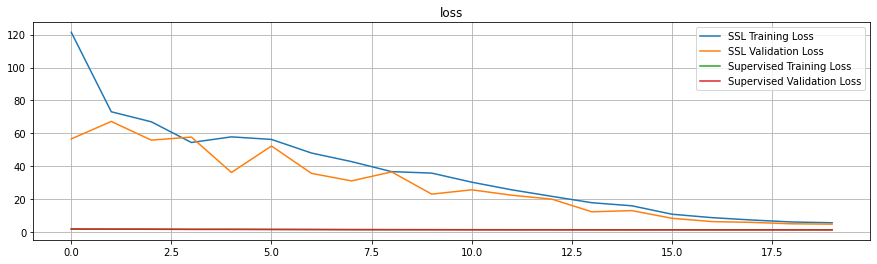

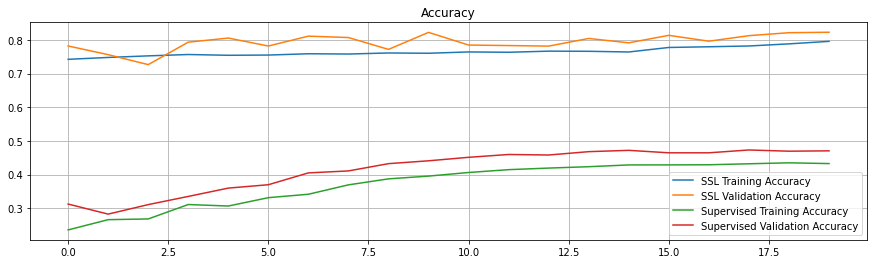

In [ ]:
TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = int(len(x_train) // BATCH_SIZE)

@tf.function
def eval_augmenter(img):
	# random resize and crop. Increase the size before we crop.
	img = tfsim.augmenters.simclr.crop_and_resize(
		img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=(0.2, 1.0)
	)
	# random horizontal flip
	img = tf.image.random_flip_left_right(img)
	img = tf.clip_by_value(img, 0.0, 255.0)

	return img

eval_train_ds = tf.data.Dataset.from_tensor_slices(
	(x_train, tf.keras.utils.to_categorical(y_train, 10))
)
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices(
	(x_val, tf.keras.utils.to_categorical(y_val, 10))
)
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices(
	(x_test, tf.keras.utils.to_categorical(y_test, 10))
)
eval_test_ds = eval_test_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
	backbone.trainable = trainable
	inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
	x = backbone(inputs, training=trainable)
	# x = tf.keras.layers.Reshape((8, 8, 8), name = 'reshape') (x)
	# x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding = 'same', name = 'grad_layer')(x)
	# x = tf.keras.layers.Flatten()(x)
	o = tf.keras.layers.Dense(10, activation="softmax")(x)
	model = tf.keras.Model(inputs, o)
	cosine_decayed_lr = tf.keras.experimental.CosineDecay(
		initial_learning_rate=lr, decay_steps=total_steps
	)
	opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
	model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
	return model

"""### No Pretrain"""
no_pt_eval_model = get_eval_model(
	img_size=CIFAR_IMG_SIZE,
	backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
	total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
	trainable=True,
	lr=1e-3,
)
print(no_pt_eval_model.summary())
no_pt_history = no_pt_eval_model.fit(
	eval_train_ds,
	batch_size=BATCH_SIZE,
	epochs=TEST_EPOCHS,
	steps_per_epoch=TEST_STEPS_PER_EPOCH,
	validation_data=eval_val_ds,
	validation_steps=VAL_STEPS_PER_EPOCH,
)

"""### Pretrained"""

pt_eval_model = get_eval_model(
	img_size=CIFAR_IMG_SIZE,
	backbone=contrastive_model.backbone,
	total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
	trainable=False,
	lr=30.0,
)

pt_eval_model.summary()
# pt_eval_model.layers[-1].trainable = True
# pt_eval_model.layers[-3].trainable = True

pt_history = pt_eval_model.fit(
	eval_train_ds,
	batch_size=BATCH_SIZE,
	epochs=TEST_EPOCHS,
	steps_per_epoch=TEST_STEPS_PER_EPOCH,
	validation_data=eval_val_ds,
	validation_steps=VAL_STEPS_PER_EPOCH,
)

"""### Comparison"""

print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))
#%%
pt_history = pt_history.history
no_pt_history = no_pt_history.history
#%%

plt.figure(figsize=(15,4))
plt.plot(pt_history["loss"], label = "SSL Training Loss")
plt.plot(pt_history["val_loss"], label = "SSL Validation Loss")
plt.plot(no_pt_history["loss"], label = "Supervised Training Loss")
plt.plot(no_pt_history["val_loss"], label = "Supervised Validation Loss")
plt.grid()
plt.title("loss")
plt.legend()
#%%
plt.figure(figsize=(15,4))
plt.plot(pt_history["acc"], label = "SSL Training Accuracy")
plt.plot(pt_history["val_acc"], label = "SSL Validation Accuracy")
plt.plot(no_pt_history["acc"], label = "Supervised Training Accuracy")
plt.plot(no_pt_history["val_acc"], label = "Supervised Validation Accuracy")
plt.grid()
plt.title("Accuracy")
plt.legend()

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/')

In [ ]:
#Saving Models
# contrastive_model.save('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models')
no_pt_eval_model.save('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models/nosimclr.h5')
pt_eval_model.save('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models/simclr.h5')

# The Pretrained (SSL) model

In [ ]:
from tensorflow import keras
import tensorflow_similarity as tfsim
import resnet18_with_attention as rscb
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models/simclr.h5')

In [ ]:
model_w = model.get_weights()
grad_model = rs.ResNet18Sim(
	(32, 32, 3),
	include_top=True,  # Take the pooling layer as the output.
	pooling= 'avg',      # Can change to use `gem` -> GeneralizedMeanPooling2D
	l2_norm = False,
	preproc_mode="torch",
)
grad_model.set_weights(model_w)
# model2 = keras.models.load_model('nosimclr.h5')
predictions = grad_model.predict(x=eval_test_ds, verbose=0)
cm = confusion_matrix(y_true=y_test.numpy(), y_pred=np.argmax(predictions, axis=-1))

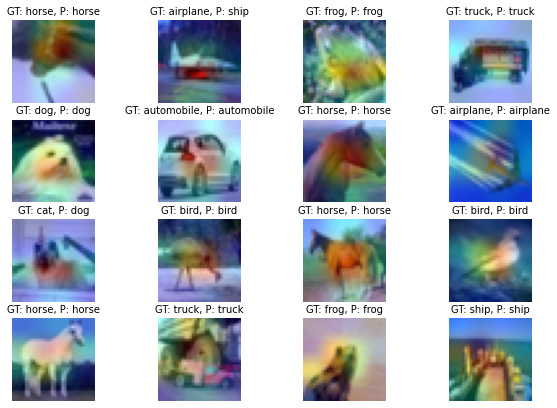

In [ ]:
sample_test = x_test.numpy()[0:16]
sample_test_labels = y_test.numpy()[0:16]
cifar_labels = {
	0 : "airplane",
	1:"automobile",
	2 : "bird",
	3 : "cat",
	4 : "deer",
	5 : "dog",
	6 : "frog",
	7 : "horse",
	8 : "ship",
	9 : "truck",
	}
rows = 4
columns = 4
fig = plt.figure(figsize=(10, 7))
for plot_id in range(rows * columns):
  img_index = plot_id
  my_sample = np.expand_dims(sample_test[img_index], 0)
  prediction = cifar_labels[np.argmax(grad_model.predict(my_sample))]
  heatmap = gm.make_gradcam_heatmap(my_sample, grad_model, 'conv5_block2_out')
  final = gm.save_and_display_gradcam(sample_test[img_index], heatmap, alpha=0.4)
  fig.add_subplot(rows, columns, plot_id + 1)
  plt.axis('off')
  plt.imshow(np.uint8(final))
  plt.title(f"GT: {cifar_labels[sample_test_labels[img_index]]}, P: {prediction}", fontsize=10)
# plt.savefig('out.jpg')





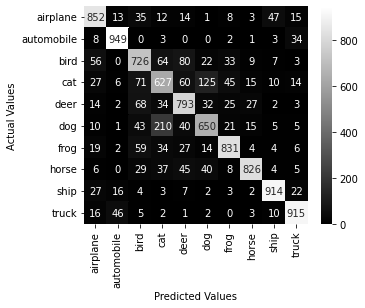

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = list(cifar_labels.values()), 
                     columns = list(cifar_labels.values()))
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='gray', fmt='g')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
cnf_matrix = cm
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
#F1 score
F1 = 2*PPV*TPR/(PPV+TPR)
#%%
conf_dict = {
	'sensitivity' : TPR,
	'specificity' : TNR,
	'precision'   : PPV,
	'F1': F1
	}
conf_df = pd.DataFrame(conf_dict)
conf_df.to_csv('simclr_self_supervised_cm.csv')

# Supervised Model

In [ ]:
from tensorflow import keras
import tensorflow_similarity as tfsim
import resnet18_with_attention as rscb
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/final_models/nosimclr.h5')

In [ ]:
model_w = model.get_weights()
grad_model = rs.ResNet18Sim(
	(32, 32, 3),
	include_top=True,  # Take the pooling layer as the output.
	pooling= 'avg',      # Can change to use `gem` -> GeneralizedMeanPooling2D
	l2_norm = False,
	preproc_mode="torch",
)
grad_model.set_weights(model_w)
# model2 = keras.models.load_model('nosimclr.h5')
predictions = grad_model.predict(x=eval_test_ds, verbose=0)
cm = confusion_matrix(y_true=y_test.numpy(), y_pred=np.argmax(predictions, axis=-1))

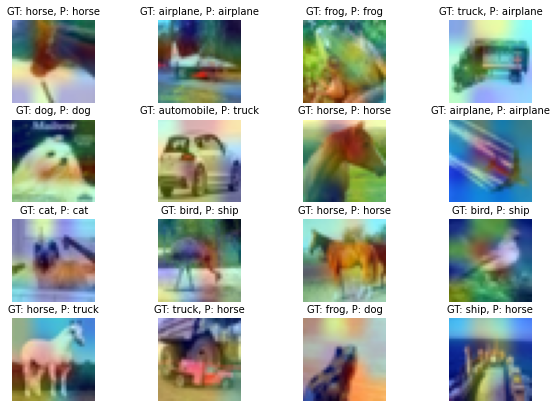

In [ ]:
sample_test = x_test.numpy()[0:16]
sample_test_labels = y_test.numpy()[0:16]
cifar_labels = {
	0 : "airplane",
	1:"automobile",
	2 : "bird",
	3 : "cat",
	4 : "deer",
	5 : "dog",
	6 : "frog",
	7 : "horse",
	8 : "ship",
	9 : "truck",
	}
rows = 4
columns = 4
fig = plt.figure(figsize=(10, 7))
for plot_id in range(rows * columns):
  img_index = plot_id
  my_sample = np.expand_dims(sample_test[img_index], 0)
  prediction = cifar_labels[np.argmax(grad_model.predict(my_sample))]
  heatmap = gm.make_gradcam_heatmap(my_sample, grad_model, 'conv5_block2_out')
  final = gm.save_and_display_gradcam(sample_test[img_index], heatmap, alpha=0.4)
  fig.add_subplot(rows, columns, plot_id + 1)
  plt.axis('off')
  plt.imshow(np.uint8(final))
  plt.title(f"GT: {cifar_labels[sample_test_labels[img_index]]}, P: {prediction}", fontsize=10)
# plt.savefig('out.jpg')





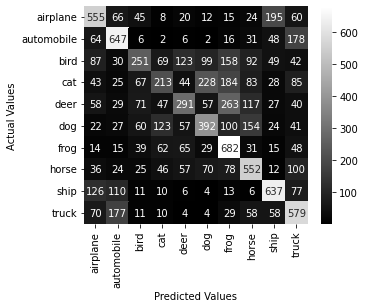

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = list(cifar_labels.values()), 
                     columns = list(cifar_labels.values()))
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='gray', fmt='g')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
cnf_matrix = cm
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
#F1 score
F1 = 2*PPV*TPR/(PPV+TPR)
#%%
conf_dict = {
	'sensitivity' : TPR,
	'specificity' : TNR,
	'precision'   : PPV,
	'F1': F1
	}
conf_df = pd.DataFrame(conf_dict)
conf_df.to_csv('simclr_supervised_cm.csv')